In [1]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.1.3
torch==1.13.0+cu117
matplotlib==3.6.2


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
#load data
data = pd.read_csv("E:\GitHub\MasterWork\Data\Day\S&P 500 Historical Data00-20.csv")

In [5]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [6]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [7]:
data.index = data.index[::-1]

In [8]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [9]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [10]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [11]:
#change indexes
#special_data.set_index('Date', inplace=True)

In [12]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [13]:
special_data.head()

,Date,Price
0,2010-01-04,1132.99
1,2010-01-05,1136.52
2,2010-01-06,1137.14
3,2010-01-07,1141.69
4,2010-01-08,1144.98


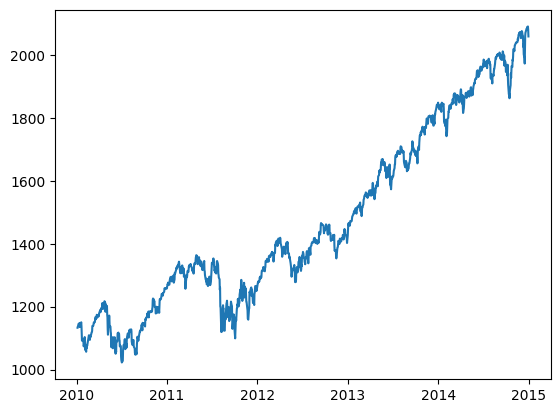

In [15]:
plt.plot(special_data.Date, special_data.Price)

In [17]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load data from csv file
data = special_data.copy()

# Normalize data using StandardScaler
# Convert dates to numerical representation
reference_date = pd.to_datetime('2000-01-01')
data['Date'] = (pd.to_datetime(data['Date']) - reference_date).dt.days

# Split data into input and label
x = data['Date'].values
y = data['Price'].values

# Normalize price values
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=False)

# Convert data to PyTorch tensors and transfer to GPU
x_train = torch.FloatTensor(x_train).view(-1, 1, 1).cuda()
y_train = torch.FloatTensor(y_train).cuda()
x_val = torch.FloatTensor(x_val).view(-1, 1, 1).cuda()
y_val = torch.FloatTensor(y_val).cuda()

In [46]:
import torch
import torch.nn as nn

class CNNForecastingModel(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=1):
        super(CNNForecastingModel, self).__init__()
        
        # Convolutional Layer
        self.conv_layer = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding)
        
        # Max Pooling Layer
        self.maxpool_layer = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(16*int((input_size/2)+1), 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        # Reshape input to (batch_size, channels, input_size)
        x = x.reshape(x.size(0), 1, -1)
        
        # Convolutional Layer
        x = self.conv_layer(x)
        
        # Max Pooling Layer
        x = self.maxpool_layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc_layers(x)
        return x

In [47]:
import torch.optim as optim

input_size = 16
output_size = 1

model = CNNForecastingModel(input_size, output_size).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define lists to store losses
train_losses = []
val_losses = []

# Set number of epochs and batch size
num_epochs = 100
batch_size = 16

# Train model
for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        model.train()  # Set model to training mode
        # Get batch of data
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Zero gradients, perform forward pass, compute loss, perform backward pass, and update weights
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # Compute training loss
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        y_train_pred = model(x_train)
        train_loss = criterion(y_train_pred, y_train)
        y_val_pred = model(x_val)
        val_loss = criterion(y_val_pred, y_val)

    # Append losses to lists
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print epoch and validation loss
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.4f}')



RuntimeError: Given input size: (16x1x1). Calculated output size: (16x1x0). Output size is too small

In [ ]:
import matplotlib.pyplot as plt

# Plot the train and validation loss curves
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()